In [8]:
import math
import random

def lcm(a,b):
    return int(abs(a * b) / math.gcd(a,b) if a and b else 0)

def lcml(lst):
    '''lcm for multiple factors'''
    if len(lst) < 2:
        return 1
    clcm = lst.pop()
    while len(lst)>0:
        clcm = lcm(lst.pop(), clcm)
    return clcm

def gcdl(lst):
    '''gcd for multiple factors'''
    if len(lst) < 2:
        return 1
    cgcd = lst.pop()
    while len(lst)>0:
        cgcd = math.gcd(lst.pop(), cgcd)
    return cgcd

if __name__=="__main__":
    a = random.randrange(10,100)
    b = random.randrange(10,100)
    print('lcm/kgV ', a, ',', b, '=', lcm(a, b))
    
    a = random.randrange(5,40)
    b = random.randrange(5,40)
    c = random.randrange(5,40)
    print('lcm/kgV: ', a,b,c,lcml([a,b,c]))
    
    a = random.randrange(10,100)
    b = random.randrange(10,100)
    print('gcd/ggT ', a, ',', b, '=', math.gcd(a, b))
    
    a = random.randrange(5,40)
    b = random.randrange(5,40)
    c = random.randrange(5,40)
    print('gcd/ggT: ', a,b,c,gcdl([a,b,c]))
    
    a = random.randrange(40,800) / 40
    b = random.randrange(40,800) / 40
    print(a, ' : ', b, '=', a/b)
    a = random.randrange(40,500) / 40
    b = random.randrange(40,500) / 40
    print(a, ' * ', b, '=', a*b)
    
    #print('lcm/kgV: ', a,b,c,lcml([52,62]))
    #print('lcm/kgV: ', a,b,c,lcml([29,8,13]))

lcm/kgV  87 , 89 = 7743
lcm/kgV:  14 38 7 266
gcd/ggT  37 , 38 = 1
gcd/ggT:  17 10 25 1
3.525  :  7.25 = 0.4862068965517241
6.875  *  4.925 = 33.859375


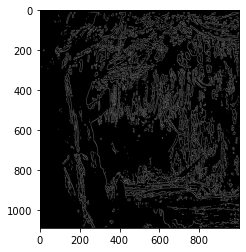

In [19]:
# canny edge detector
import numpy as np
from scipy.ndimage.filters import convolve, gaussian_filter
#from scipy.misc import imread, imshow
#from matplotlib.pyplot import imread, imshow
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
 
def CannyEdgeDetector(im, blur = 1, highThreshold = 91, lowThreshold = 31):
    im = np.array(im, dtype=float) #Convert to float to prevent clipping values
    
    # Gaussian blur to reduce noise
    im2 = gaussian_filter(im, blur)

    # Use sobel filters to get horizontal and vertical gradients
    im3h = convolve(im2,[[-1,0,1],[-2,0,2],[-1,0,1]]) 
    im3v = convolve(im2,[[1,2,1],[0,0,0],[-1,-2,-1]])

    # Get gradient and direction
    grad = np.power(np.power(im3h, 2.0) + np.power(im3v, 2.0), 0.5)
    theta = np.arctan2(im3v, im3h)
    thetaQ = (np.round(theta * (5.0 / np.pi)) + 5) % 5 #Quantize direction

    #Non-maximum suppression
    gradSup = grad.copy()
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            # Suppress pixels at the image edge
            if r == 0 or r == im.shape[0]-1 or c == 0 or c == im.shape[1] - 1:
                gradSup[r, c] = 0
                continue
            tq = thetaQ[r, c] % 4

            if tq == 0: #0 is E-W (horizontal)
                if grad[r, c] <= grad[r, c-1] or grad[r, c] <= grad[r, c+1]:
                    gradSup[r, c] = 0
            if tq == 1: #1 is NE-SW
                if grad[r, c] <= grad[r-1, c+1] or grad[r, c] <= grad[r+1, c-1]:
                    gradSup[r, c] = 0

            if tq == 2: #2 is N-S (vertical)
                if grad[r, c] <= grad[r-1, c] or grad[r, c] <= grad[r+1, c]:
                    gradSup[r, c] = 0
                    
            if tq == 3: #3 is NW-SE
                if grad[r, c] <= grad[r-1, c-1] or grad[r, c] <= grad[r+1, c+1]:
                    gradSup[r, c] = 0
            
    # Double threshold
    strongEdges = (gradSup > highThreshold)
    # Strong has value 2, weak has value 1
    thresholdedEdges = np.array(strongEdges, dtype=np.uint8) + (gradSup > lowThreshold)

    # Tracing edges with hysteresis	

    # Find weak edge pixels near strong edge pixels
    finalEdges = strongEdges.copy()

    currentPixels = []
    for r in range(1, im.shape[0]-1):
        for c in range(1, im.shape[1]-1):	
            if thresholdedEdges[r, c] != 1:
                continue # Not a weak pixel

            # Get 3x3 patch	
            localPatch = thresholdedEdges[r-1:r+2,c-1:c+2]
            patchMax = localPatch.max()
            if patchMax == 2:
                currentPixels.append((r, c))
            finalEdges[r, c] = 1

    # Extend strong edges based on current pixels
    while len(currentPixels) > 0:
        newPix = []
        for r, c in currentPixels:
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if dr == 0 and dc == 0: continue
                    r2 = r+dr
                    c2 = c+dc
                    if thresholdedEdges[r2, c2] == 1 and finalEdges[r2, c2] == 0:
                        # Copy this weak pixel to final result
                        newPix.append((r2, c2))
                        finalEdges[r2, c2] = 1
                    currentPixels = newPix

    return finalEdges

if __name__=="__main__":
    #im = Image.open('mw01.jpg') #Open image, convert to greyscale
    im = mpimg.imread('mw01.jpg')
    im_gray = rgb2gray(im)
    finalEdges = CannyEdgeDetector(im_gray)
    #mpimg.imshow(finalEdges)
    plt.imshow(finalEdges, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()

In [6]:
# align columns
from itertools import zip_longest
 
txt = """Given$a$txt$file$of$many$lines,$where$fields$within$a$line$
are$delineated$by$a$single$'dollar'$character,$write$a$program
that$aligns$each$column$of$fields$by$ensuring$that$words$in$each$
column$are$separated$by$at$least$one$space.
Further,$allow$for$each$word$in$a$column$to$be$either$left$
justified,$right$justified,$or$center$justified$within$its$column."""
 
parts = [line.rstrip("$").split("$") for line in txt.splitlines()]
widths = [max(len(word) for word in col) 
          for col in zip_longest(*parts, fillvalue='')]
 
for justify in "<_Left ^_Center >_Right".split():
    j, jtext = justify.split('_')
    print(f"{jtext} column-aligned output:\n")
    for line in parts:
        print(' '.join(f"{wrd:{j}{wdth}}" for wdth, wrd in zip(widths, line)))
    print("- " * 52)

Left column-aligned output:

Given      a          txt        file   of     many      lines,     where    fields  within  a      line
are        delineated by         a      single 'dollar'  character, write    a       program
that       aligns     each       column of     fields    by         ensuring that    words   in     each
column     are        separated  by     at     least     one        space.  
Further,   allow      for        each   word   in        a          column   to      be      either left
justified, right      justified, or     center justified within     its      column.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Center column-aligned output:

  Given        a         txt      file    of     many      lines,    where   fields  within    a    line
   are     delineated     by       a    single 'dollar'  character,  write      a    program
   that      aligns      each    column   of    fields       by    

In [22]:
# pandas import test
import pandas as pd
import os

MY_PATH = r'C:\Users\bscho\Documents\DL\lrgtxt0'
os.chdir(MY_PATH)
data = pd.read_excel (r'Janssen_Neuro_mit_Tendenzen_und_Insights_202010.xlsx')
# df = pd.read_excel (r'Path where the Excel file is stored\File name.xlsx', sheet_name='your Excel sheet name')
df = pd.DataFrame(data, columns= ['Nachname']) # as a test, choose a column
print (df)

               Nachname
0                  Dürr
1               Poustka
2                Behrus
3                Kleber
4            Innerhofer
...                 ...
1937  Ücker-Geischläger
1938             Huemer
1939             Huemer
1940      Hüttenbrenner
1941  Hünlein-Hillinger

[1942 rows x 1 columns]


In [9]:
# rakkimaths
import random

def bcalc(nlim=50):
    f0 = random.randint(10,nlim)
    f1 = random.randint(0,f0-1)
    s0 = random.choice([0,1]) # 0=+, 1=-
    if s0==0:
        r0 = f0 + f1
    else:
        r0 = f0 - f1
    return [f0, s0, f1, r0]

def pclc(ctpl):
    if ctpl[1] == 0:
        print(ctpl[0],'+',ctpl[2],'=',ctpl[3])
    else:
        print(ctpl[0],'-',ctpl[2],'=',ctpl[3])

if __name__=="__main__":
    for i in range(5):
        clc0 = bcalc()
        pclc(clc0)
        clc0[random.choice([0,2,3])] = 0
        pclc(clc0)
        print('**************')

47 - 4 = 43
0 - 4 = 43
**************
45 + 16 = 61
45 + 0 = 61
**************
25 - 0 = 25
25 - 0 = 25
**************
25 + 17 = 42
0 + 17 = 42
**************
47 - 39 = 8
47 - 0 = 8
**************


In [2]:
# simplifications
def qdrexp(a):
    if a[0]=='(':
        ac = a + '*' + a
    elif a.isnumeric():
        ac = str(int(a)**2)
    else:
        ac = str(int(a[0:-1])**2) + a[-1:] + '*' + a[-1:] 
    return ac

def mulexp(a,b):
    if a[0]=='(' or b[0]=='(':
        ac = a + '*' + b
    elif a.isnumeric() and b.isnumeric():
        ac = str(int(a)*int(b))
    elif a.isnumeric() and not b.isnumeric():
        ac = str(int(a)*int(b[0:-1])) + '*' + b[-1:]
    elif not a.isnumeric() and b.isnumeric():
        ac = str(int(a[0:-1])*int(b)) + '*' + a[-1:]
    else:
        ac = str(int(a[0:-1])*int(b[0:-1])) + a[-1:] + '*' + b[-1:] 
    return ac   

def binom(a,b):
    return '(' + qdrexp(a) + ' - ' + qdrexp(b) + ')'

def quadr(a,b):
    return '(' + qdrexp(a) + ' + 2*' + mulexp(a,b) + ' + ' + qdrexp(b) + ')'

if __name__=="__main__":
    print(binom('12x','3'))
    print(binom('(2x-3)','3'))
    print(quadr('12x','3'))

(144x*x - 9)
((2x-3)*(2x-3) - 9)
(144x*x + 2*36*x + 9)


In [12]:
d = {"Month":[1,2,3,4,5,6],"Rain":[30,40,50,20,30,70]}
#new_d = {"Month":[2,4,6],"Rain":[40,20,70]}
mths_to_choose = [2,4,6]

for keyval in d.items():
    new_d[keyval[0]] = []
    for i in mths_to_choose: # if filter_string in key: # do something
        new_d[keyval[0]].append(keyval[1][i-1])
    # else# do nothing, continue  
print(new_d)

new_d = {ditms[0]: [ditms[1][i-1] for i in mths_to_choose] for ditms in d.items()}
print(new_d)

{'Month': [2, 4, 6], 'Rain': [40, 20, 70]}
{'Month': [2, 4, 6], 'Rain': [40, 20, 70]}


In [13]:
# Chinese remainder
from functools import reduce

def chinese_remainder(n, a):
    sum = 0
    prod = reduce(lambda a, b: a*b, n)
    for n_i, a_i in zip(n, a):
        p = prod // n_i
        sum += a_i * mul_inv(p, n_i) * p
    return sum % prod

def mul_inv(a, b):
    b0 = b
    x0, x1 = 0, 1
    if b == 1: return 1
    while a > 1:
        q = a // b
        a, b = b, a%b
        x0, x1 = x1 - q * x0, x0
    if x1 < 0: x1 += b0
    return x1

if __name__ == '__main__':
    n = [3, 5, 7]
    a = [2, 3, 2]
    print(chinese_remainder(n, a))

23


In [1]:
# splitting strings
numbers = '0123456789'
operators = '^/*+-%dr='

inp = '3096+41*12-dd+31^2rrr'

outp = []
cn = '' # current number 
for i in range(len(inp)):
    if inp[i] in numbers: # check string element-wise
        cn += inp[i] # compile current number
    elif inp[i] in operators:
        if len(cn) > 0: # we have an integer in store (as string)
            outp.append(int(cn)) # which we append as int
            cn = '' # and clear for the next number
        outp.append(inp[i])
    else:
        pass # todo: non-treatable tokens

print(outp)
#outp = [3096,+,41,*,12,-,d,d,+,31,2,r,r,r]

[3096, '+', 41, '*', 12, '-', 'd', 'd', '+', 31, '^', 2, 'r', 'r', 'r']


In [59]:
inp = [[('A Sam', 'count1'), 1], [('A Sam', 'count2'), 2], [('T King', 'count1'), 2], [('C Baskin', 'count2'), 1]]
outp = {"A Sam": [1,2], "T King": [2,0], "C Baskin": [0,1]} # "name": [position_ct1, position_ct2]

ctmp = lambda x: 'count' + x
ctimp = lambda x: int(x.replace('count',''))
ctimpl = lambda x: [idx if idx == int(x.replace('count',''))-1 else 0 for idx in range(2)]

#print([ctimp(el[0][1]) for el in inp])

print([ctimpl(el[0][1]) for el in inp])

ctl = [1, 2]
print({dcel: [ctl[ctimp(el[0][1])-1] for el in inp if el[0][0] == dcel] for dcel in set([inpel[0][0] for inpel in inp])})

[[0, 0], [0, 1], [0, 0], [0, 1]]
{'A Sam': [1, 2], 'C Baskin': [2], 'T King': [1]}


In [1]:
import math

PI = 3.14159265358979323846

def fatorial(n):
    fatorial = 1
    for i in range(1,n+1,1):
        fatorial = fatorial * i
    return fatorial 

def seno(theta): 
    n = 1
    k = 3
    #eps = 10**-10
    theta = (theta*PI)/180
    thetas = theta # <- added this
    x = -theta*theta*theta
    y = 6
    #while x/y > eps or x/y < -eps:
    while k < 14:
        thetas = thetas + (x/y) # sum thetas
        n = n + 1
        k = k + 2
        #x = ((-1)**n) * ((theta)**k)
        x = ((-1)**(n%2)) * ((theta)**k) # but use the original value for the series
        #y = fatorial(k)
        y *= k * (k-1)
    return thetas # return the sum

if __name__ == '__main__':
    print(seno(80), math.sin(8*PI/18))

0.984807753125684 0.984807753012208


In [ ]:
I was training a Transformer model to convert English sentences to German. After training it for not even for 1 epoch, the loss went down to 0.009. This was very surprising for me... So, I tried testing it on both the training and testing data set, and in both, it was not producing the right words! If the loss is so low, then it should predict the right words, at least on the training set.

Code
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, Dense, Dropout, BatchNormalization, TimeDistributed, AdditiveAttention, Input, Concatenate, Flatten
from tensorflow.keras.layers import Activation, LayerNormalization, GRU, GlobalAveragePooling1D, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import tanh, softmax
import time
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from numpy import array
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
import time
import tensorflow as tf
from numpy import array
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets.imdb import load_data

def load_data(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def to_lines(text):
    return text.split('\n')

def clean_data(pair):
    pair = 'start_seq_ ' + pair + ' end_seq_'

    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in pair.split()]
    tokens = [token.lower() for token in tokens]
    tokens = [re_print.sub('', token) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

lines = to_lines(load_data('/content/drive/My Drive/spa.txt'))

english_pair = []
german_pair = []
language = []
for line in lines:
    if line != '':
        pairs = line.split('\t')
        english_pair.append(clean_data(pairs[0]))
        german_pair.append(clean_data(pairs[1]))

        language.append(clean_data(pairs[0]))
        language.append(clean_data(pairs[1]))

english_pair = array(english_pair)
german_pair = array(german_pair)
language = array(language)

def create_tokenizer(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer

def max_len(lines):
    length = []
    for line in lines:
        length.append(len(line))
    return max(length)

tokenizer = create_tokenizer(language)

vocab_size = len(tokenizer.word_index) + 1

max_len = max_len(language)

# Convert into numbers
def create_sequences(sequences, max_len):
    sequences = tokenizer.texts_to_sequences(sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return sequences

X1 = create_sequences(english_pair, max_len)
X2 = create_sequences(german_pair, max_len)
Y = create_sequences(german_pair, max_len)

# Shuffle
X1, X2, Y = shuffle(X1, X2, Y)

# Split into train and test
training_samples = int(X1.shape[0] * 0.8)

train_x1, train_x2, train_y = X1[:training_samples], X2[:training_samples], Y[:training_samples]
test_x1, test_x2, test_y = X1[training_samples:], X2[training_samples:], Y[training_samples:]

# The German sentence input to the decoder, would not contain the last '0' and the expected german output would not contain the token 'startseq'

train_x2, test_x2 = train_x2[:, :-1], test_x2[:, :-1]
train_y = train_y[:, 1:].reshape(-1, max_len-1)
test_y = test_y[:, 1:].reshape(-1, max_len-1)

# After doing it, the length is reduced by 1, so we need to make it of the same length as the english sentence

train_x2 = pad_sequences(train_x2, maxlen=max_len, padding='post')
test_x2 = pad_sequences(test_x2, maxlen=max_len, padding='post')

train_y = pad_sequences(train_y, maxlen=max_len, padding='post')
test_y = pad_sequences(test_y, maxlen=max_len, padding='post')

# Now we Make the Transformer Model

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, mid_ffn_dim, embed_dim, num_heads, max_len, batch_size):
        super(EncoderBlock, self).__init__()
        # Variables
        self.batch_size = batch_size
        self.max_len = max_len
        self.mid_ffn_dim = mid_ffn_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention_vector_len = self.embed_dim // self.num_heads
        if self.embed_dim % self.num_heads != 0:
            raise ValueError('I am Batman!')

        # Trainable Layers
        self.mid_ffn = Dense(self.mid_ffn_dim, activation='relu')
        self.final_ffn = Dense(self.embed_dim)

        self.layer_norm1 = LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = LayerNormalization(epsilon=1e-6)

        self.combine_heads = Dense(self.embed_dim)

        self.query_dense = Dense(self.embed_dim)
        self.key_dense = Dense(self.embed_dim)
        self.value_dense = Dense(self.embed_dim)

    def separate_heads(self, x):
        x = tf.reshape(x, (-1, self.max_len, self.num_heads, self.attention_vector_len))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def compute_self_attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def self_attention_layer(self, x):
        query = self.query_dense(x)
        key = self.key_dense(x)
        value = self.value_dense(x)

        query_heads = self.separate_heads(query)    
        key_heads = self.separate_heads(key)
        value_heads = self.separate_heads(value)

        attention = self.compute_self_attention(query_heads, key_heads, value_heads)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        attention = tf.reshape(attention, (-1, self.max_len, self.embed_dim))

        output = self.combine_heads(attention)
        return output
        
    def get_output(self, x):
        attn_output = self.self_attention_layer(x)
        out1 = self.layer_norm1(x + attn_output)

        ffn_output = self.final_ffn(self.mid_ffn(out1))

        encoder_output = self.layer_norm2(out1 + ffn_output)
        return encoder_output

class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, mid_ffn_dim, embed_dim, num_heads, max_len, batch_size):
        super(DecoderBlock, self).__init__()
        # Variables
        self.batch_size = batch_size
        self.max_len = max_len
        self.mid_ffn_dim = mid_ffn_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention_vector_len = self.embed_dim // self.num_heads
        if self.embed_dim % self.num_heads != 0:
            raise ValueError('I am Batman!')

        # Trainable Layers

        self.query_dense1 = Dense(self.embed_dim, name='query_dense1')
        self.key_dense1 = Dense(self.embed_dim, name='key_dense1')
        self.value_dense1 = Dense(self.embed_dim, name='value_dense1')

        self.mid_ffn = Dense(self.mid_ffn_dim, activation='relu', name='dec_mid_ffn')
        self.final_ffn = Dense(self.embed_dim, name='dec_final_ffn')

        self.layer_norm1 = LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = LayerNormalization(epsilon=1e-6)

        self.combine_heads = Dense(self.embed_dim, name='dec_combine_heads')

        self.query_dense2 = Dense(self.embed_dim, name='query_dense2')
        self.key_dense2 = Dense(self.embed_dim, name='key_dense2')
        self.value_dense2 = Dense(self.embed_dim, name='value_dense2')

    def separate_heads(self, x):
        x = tf.reshape(x, (-1, self.max_len, self.num_heads, self.attention_vector_len))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def compute_self_attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def masking(self, x):
        b = []
        for batch in range(x.shape[0]):
            bat = []
            for head in range(x.shape[1]):
                headd = []
                for word in range(x.shape[2]):
                    current_word = []
                    for represented_in in range(x.shape[3]):
                        if represented_in > word:
                          current_word.append(np.NINF)
                        else:
                          current_word.append(0)
                    headd.append(current_word)
                bat.append(headd)
            b.append(bat)
        return b

    def compute_masked_self_attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        score = score + self.masking(score)
        score = tf.convert_to_tensor(score)
                
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def masked_self_attention_layer(self, x):
        query = self.query_dense1(x)
        key = self.key_dense1(x)
        value = self.value_dense1(x)

        query_heads = self.separate_heads(query)    
        key_heads = self.separate_heads(key)
        value_heads = self.separate_heads(value)

        attention = self.compute_masked_self_attention(query_heads, key_heads, value_heads)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        attention = tf.reshape(attention, (-1, self.max_len, self.embed_dim))

        output = self.combine_heads(attention)
        return output

    def second_attention_layer(self, x, encoder_output):
        query = self.query_dense2(x)
        key = self.key_dense2(encoder_output)
        value = self.value_dense2(encoder_output)

        query_heads = self.separate_heads(query)    
        key_heads = self.separate_heads(key)
        value_heads = self.separate_heads(value)

        attention = self.compute_self_attention(query_heads, key_heads, value_heads)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        attention = tf.reshape(attention, (-1, self.max_len, self.embed_dim))

        output = self.combine_heads(attention)
        return output
      
    def get_output(self, x, encoder_output):
        masked_attn_output = self.masked_self_attention_layer(x)
        out1 = self.layer_norm1(x + masked_attn_output)

        mutli_head_attn_output = self.second_attention_layer(out1, encoder_output)
        out2 = self.layer_norm2(out1 + mutli_head_attn_output)

        ffn_output = self.final_ffn(self.mid_ffn(out2))
        decoder_output = self.layer_norm3(out2 + ffn_output)
        return decoder_output

# Initialize the variables
embed_dim = 256
mid_ffn_dim = 512

num_heads = 8
max_len = max_len
batch_size = 32

# Make the Encoder and Decoder Blocks
encoder_block1 = EncoderBlock(mid_ffn_dim, embed_dim, num_heads, max_len, batch_size)
decoder_block1 = DecoderBlock(mid_ffn_dim, embed_dim, num_heads, max_len, batch_size)


# Define Loss and Optimizer
loss_object = SparseCategoricalCrossentropy()
optimizer = Adam()

embedding = Embedding(vocab_size, embed_dim, name='embedding')
position_embedding = Embedding(vocab_size, embed_dim, name='positioning_embedding')

final_transformer_layer = Dense(vocab_size, activation='softmax', name='final_prediction_layer')

def positional_embedding(x):
    positions = tf.range(start=0, limit=max_len, delta=1)
    positions = position_embedding(positions)
    return x + positions

def train_step(english_sent, german_sent, german_trgt):
    with tf.GradientTape() as tape:
        english_embedded = embedding(english_sent)
        german_embedded = embedding(german_sent)

        english_positioned = positional_embedding(english_embedded)
        german_positioned = positional_embedding(german_embedded)

        # Encoders
        encoder_output = encoder_block1.get_output(english_positioned)

        # Decoders
        decoder_output = decoder_block1.get_output(german_positioned, encoder_output)

        # Final Output
        transformer_output = final_transformer_layer(decoder_output)
        # Compute Loss
        loss = loss_object(german_trgt, transformer_output)

    variables = embedding.trainable_variables + position_embedding.trainable_variables + encoder_block1.trainable_variables
    variables += decoder_block1.trainable_variables + final_transformer_layer.trainable_variables

    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return float(loss/max_len)

def train(epochs=10):
    batch_per_epoch = int(train_x1.shape[0] / batch_size)
    for epoch in range(epochs):
        for i in range(batch_per_epoch):
            english_sent_x = train_x1[i*batch_size : (i+1)*batch_size].reshape(batch_size, max_len)
            german_sent_x = train_x2[i*batch_size : (i+1)*batch_size].reshape(batch_size, max_len)
            german_sent_y = train_y[i*batch_size : (i+1)*batch_size].reshape(batch_size, max_len, 1)

            loss = train_step(english_sent_x, german_sent_x, german_sent_y)

            print('Epoch ', epoch, 'Batch ', i, '/', batch_per_epoch, 'Loss ', loss)

train()

In [ ]:
def get_output_word(prediction):
    prediction = np.argmax(prediction, axis=-1)
    for word, index in tokenizer.word_index.items():
        if index == prediction:
            return word
    return '0'

def to_words(sequence):
    text = ''
    for num in sequence:
        for word, index in tokenizer.word_index.items():
            if index == num:
                text += word + ' '
    return text

def Inference(english_sent_x, german_sent_x):
    english_sequences = tokenizer.texts_to_sequences(english_sent_x)
    english_sequences = pad_sequences([english_sequences], maxlen=max_len, padding='post').reshape(1, max_len)

    german_sequences = tokenizer.texts_to_sequences(german_sent_x)
    german_sequences = pad_sequences([german_sequences], maxlen=max_len, padding='post').reshape(1, max_len)

    predicted_sentence = 'startseq'

    i = 1
    while True:
        english_embedded = embedding(english_sequences)
        german_embedded = embedding(german_sequences)

        english_positioned = positional_embedding(english_embedded)
        german_positioned = positional_embedding(german_embedded)

        # Encoders
        encoder_output = encoder_block1.get_output(english_positioned)

        # Decoders
        decoder_output = decoder_block1.get_output(german_positioned, encoder_output)

        # Final Output
        transformer_output = final_transformer_layer(decoder_output)[0]

        output_word = get_output_word(transformer_output[i-1])

        german_sequences[0, i] = np.argmax(transformer_output[i-1], axis=-1)

        predicted_sentence += ' ' + output_word

        i += 1

        if predicted_sentence.split()[-1] == 'endseq' or len(predicted_sentence.split()) == max_len:
            return predicted_sentence

index = 10995
english_sent = train_x1[index]
spanish_sent = train_y[index]
prediction = Inference(to_words(english_sent).split(), ['startseq'])

print('English Sentence: ', to_words(english_sent))
print('Predicted Spanish Sentence: ', prediction)
print('True Spanish Sentence: ', to_words(spanish_sent))

In [4]:
# cartesian product
#{1, 2} × {3, 4} = {(1, 3), (1, 4), (2, 3), (2, 4)}
#{3, 4} × {1, 2} = {(3, 1), (3, 2), (4, 1), (4, 2)}

def cartp(l0, l1):
    '''cartesian product of two lists'''
    return [(el0, el1) for el0 in l0 for el1 in l1]

if __name__ == '__main__':
    l0 = [1, 2]
    l1 = [3, 4]
    print(cartp(l0, l1))
    l0 = [3, 4]
    l1 = [1, 2]
    print(cartp(l0, l1))
    l0 = [1, 2]
    l1 = []
    print(cartp(l0, l1))

[(1, 3), (1, 4), (2, 3), (2, 4)]
[(3, 1), (3, 2), (4, 1), (4, 2)]
[]


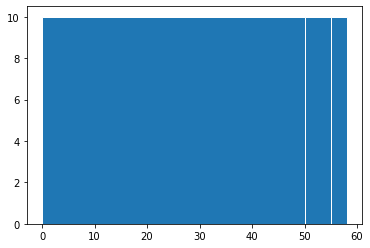

In [9]:
# matplotlib variwide
import matplotlib.pyplot as plt

plt.bar([0,50,55], [10,10,10], [50,5,3], align='edge', edgecolor='w')
plt.show()

In [3]:
import pandas as pd
import numpy as np

dataset = pd.DataFrame(np.random.randint(0,3,size=(5, 8)), columns=list('ABCDEFGH'))

print(dataset)

'''df = pd.concat([dataset['A'].value_counts(normalize=True).mul(100),
               dataset['B'].value_counts(normalize=True).mul(100),
               dataset['C'].value_counts(normalize=True).mul(100),
                dataset['D'].value_counts(normalize=True).mul(100),
               dataset['E'].value_counts(normalize=True).mul(100),
               dataset['F'].value_counts(normalize=True).mul(100),
               dataset['G'].value_counts(normalize=True).mul(100),
               dataset['H'].value_counts(normalize=True).mul(100)],
               axis=1,keys=('proportions A','proportions B',
                           'proportions C', 'proportions D',
                           'proportions E', 'proportions F',
                           'proportions G', 'proportions H'))

print(df)'''

df = pd.concat([dataset[colid].value_counts(normalize=True).mul(100) for colid in list('ABCDEFGH')],
              axis=1,keys=('proportions ' + colid for colid in list('ABCDEFGH')))

print(df)

   A  B  C  D  E  F  G  H
0  0  0  0  1  2  0  2  0
1  2  0  2  1  1  1  0  1
2  2  1  0  2  2  1  1  0
3  2  1  2  1  0  0  1  2
4  2  1  0  2  0  0  2  0
   proportions A  proportions B  proportions C  proportions D  proportions E  \
0           20.0           40.0           60.0            NaN           40.0   
1            NaN           60.0            NaN           60.0           20.0   
2           80.0            NaN           40.0           40.0           40.0   

   proportions F  proportions G  proportions H  
0           60.0           20.0           60.0  
1           40.0           40.0           20.0  
2            NaN           40.0           20.0  


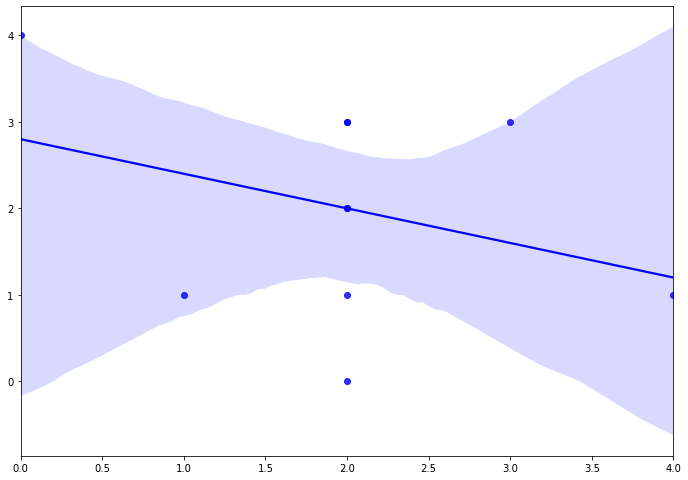

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

calibration_dep = np.random.randint(0,5,size=10)
a4_dims = (11.7, 8.27)  # addint the dimentions that will be used for the plot
fig, ax = plt.subplots(figsize=a4_dims)
#sns.regplot(data=calibration_dep, x='flow_rate', y='voltage', ax=ax, color='blue')
sns.regplot(x=np.random.randint(0,5,size=10), y=np.random.randint(0,5,size=10), ax=ax, color='blue', label='full')

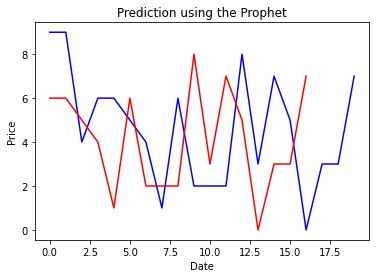

In [22]:
# plotting of predictions with actual values from 30-09-2020 until 30-10-2020; Combine Prediction and actual values
#m_data_DJI_recent.plot(prediction_2)
df_DJI = np.random.randint(0,10,size=20)
plt.plot(df_DJI, color = "blue")
plt.plot(df_DJI[3:], color = "red")  # limit range of plot
plt.title("Prediction using the Prophet")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [23]:
import random
 
s = ('It is certain', 'It is decidedly so', 'Without a doubt', 'Yes, definitely',
 'You may rely on it', 'As I see it, yes', 'Most likely', 'Outlook good',
 'Signs point to yes', 'Yes', 'Reply hazy, try again', 'Ask again later',
 'Better not tell you now', 'Cannot predict now', 'Concentrate and ask again',
 "Don't bet on it", 'My reply is no', 'My sources say no', 'Outlook not so good',
 'Very doubtful')
 
q_and_a = {}
 
while True:
    question = input('Ask your question:')
    if len(question) == 0: break
 
    answer = random.choice(s)
 
    if question in q_and_a:
        print('Your question has already been answered')
    else:
        q_and_a[question] = answer
        print(answer)

Ask your question:what is my birthday
It is decidedly so
Ask your question:


In [10]:
a = 23.134
print('%3.5f' %a)

b1 = 3.5
a = 23.134
optfmt = '%' + str(b1) + 'f'
print(optfmt %a)

23.13400
23.13400


In [13]:
bin(1533)

'0b10111111101'

In [25]:
#Import Modules
import re
import requests
from bs4 import BeautifulSoup

#Get page
cartridge_url = 'https://escapefromtarkov.gamepedia.com/7.62x25mm_Tokarev'
cartridge_page = requests.get(cartridge_url)
cartridge_soup = BeautifulSoup(cartridge_page.content, 'html.parser')

#This gets the rows of the table I want
#dirty_temp_type = cartridge_soup.find_all(lambda t: t.name =='tr')
#dirty_temp_type = cartridge_soup.find_all('th')
#print(dirty_temp_type[:20])

for row in cartridge_soup.find_all("tr")[2:]:
    print([cell.get_text(strip=True) for cell in row.find_all("td")])

#This gets rid of an element which is not useful
#filthy_dirty_temp_type = [n for n in dirty_temp_type if not 'class="va-navbox' in str(n)]
#print(filthy_dirty_temp_type)

#I had hoped this might assemble a list..  
#filthy_dirty_temp_type = [str(n) for n in filthy_dirty_temp_type]

'''html_list  = [<tr>
         <th><a href="/7.62x25mm_TT_AKBS" title="7.62x25mm TT AKBS"><img alt="TTAKBS.png" decoding="async" height="64" src="https://static.wikia.nocookie.net/escapefromtarkov_gamepedia/images/6/61/TTAKBS.png/revision/latest/scale-to-width-down/64?cb=20190519001904" width="64"/></a>
         </th>
         <th><a href="/7.62x25mm_TT_AKBS" title="7.62x25mm TT AKBS">7.62x25mm TT AKBS</a>
         </th>
         <td>58
         </td>
         <td>12
         </td>
         <td>32]'''

'''list  = ['href="/7.62x25mm_TT_AKBS" title="7.62x25mm TT AKBS"><img alt="TTAKBS.png" decoding="async" height="64" src="https://static.wikia.nocookie.net/escapefromtarkov_gamepedia/images/6/61/TTAKBS.png/revision/latest/scale-to-width-down/64?cb=20190519001904" width="64"',
         'href="/7.62x25mm_TT_AKBS" title="7.62x25mm TT AKBS">7.62x25mm TT AKBS',
         '58',
         '12',
         '32']'''



['60', '11', '29', '', '', '25%', '6.5%', '427', '', 'PraporLL1']
['64', '8', '28', '+5', '-5', '35%', '5%', '375', '', 'JaegerLL1']
['66', '7', '27', '+10', '-10', '35%', '5%', '385', '', 'JaegerLL2']
['58', '14', '32', '', '', '25%', '6.5%', '430', '', 'PraporLL2']
['50', '25', '36', '', '', '20%', '10%', '430', '', 'PraporLL3']
['55', '18', '34', '-10', '', '16.6%', '10%', '415', 'Tracer', 'PraporLL2']
['RoundsPistol cartridges7.62x25mm TokarevAKBS·FMJ43·LRN·LRNPC·P gl·Pst gzh·PT gzh9x18mm Makarov9 BZT gzh·9 P gzh·PBM·PMM·PPe gzh·PPT gzh·PRS gs·PS gs PPO·PSO gzh·Pst gzh·PSV·RG028 gzh·SP7 gzh·SP8 gzh9x19mm Parabellum7N31·AP 6.3·Green Tracer·Luger CCI·PSO gzh·Pst gzh·RIP·QuakeMaker9x21mm GyurzaSP10·SP11·SP12·SP13.45 ACPAP·FMJ·Hydra-Shok·Lasermatch·RIPPDW cartridges4.6x30mm HKAction SX·AP SX·FMJ SX·Subsonic SX5.7x28mm FNL191·R37.F·R37.X·SB193·SS190·SS197SR·SS198LFRifle cartridges (RU)5.45x39mm7N39 "Igolnik"·BP·BS·BT·FMJ·HP·PP·PRS·PS·SP·T·US7.62x39mmBP·HP·PS·T45M·US7.62x54mmR7BT1·7N1 Sn

'list  = [\'href="/7.62x25mm_TT_AKBS" title="7.62x25mm TT AKBS"><img alt="TTAKBS.png" decoding="async" height="64" src="https://static.wikia.nocookie.net/escapefromtarkov_gamepedia/images/6/61/TTAKBS.png/revision/latest/scale-to-width-down/64?cb=20190519001904" width="64"\',\n         \'href="/7.62x25mm_TT_AKBS" title="7.62x25mm TT AKBS">7.62x25mm TT AKBS\',\n         \'58\',\n         \'12\',\n         \'32\']'

In [32]:
l = ['hi', 'my', 'name', 'is', 'john', '\n', '\n', 'nice', 'to', 'meet', 'you']

lst = []
ls = []
for word in l:
    if word != '\n':
        ls.append(word)
    else:
        if len(ls) > 0:
            lst.append(ls)
            ls = []
if len(ls) > 0:
            lst.append(ls)
print(lst)

[['hi', 'my', 'name', 'is', 'john'], ['nice', 'to', 'meet', 'you']]


In [1]:
import pandas as pd
import numpy as np

# https://rosettacode.org/wiki/Longest_common_substring#Python
def longestCommon(s1, s2):
    len1, len2 = len(s1), len(s2)
    ir, jr = 0, -1
    for i1 in range(len1):
        i2 = s2.find(s1[i1])
        while i2 >= 0:
            j1, j2 = i1, i2
            while j1 < len1 and j2 < len2 and s2[j2] == s1[j1]:
                if j1-i1 >= jr-ir:
                    ir, jr = i1, j1
                j1 += 1; j2 += 1
            i2 = s2.find(s1[i1], i2+1)
    return len(s1[ir:jr+1])

df1 = pd.DataFrame({'Name':['Jon','Alex','Jenny','Rick','Joe'], 'Color':['Red', 'Blue', 'Green', 'Black', 'Yellow'], 
                    'Tel':['3745 569', '785 985', '635 565a', '987', np.nan]})
df2 = pd.DataFrame({'Phone':['987 856','985', np.nan, '569','459 56']})

# left merge df2 to df1 via longest matching substring Tel to Phone
mrglst = []
for phone in df2['Phone']:
    lgstr = 0
    lgtel = ''
    lgcol = ''
    for tidx, trow in df1.iterrows():
        if str(phone) != 'nan' and str(trow['Tel']) != 'nan':
            thisstrl = longestCommon(phone, trow['Tel'])
            if thisstrl > lgstr:
                lgstr = thisstrl
                lgtel, lgcol = trow['Tel'], trow['Color']
    mrglst.append([phone, lgtel, lgcol])
    
dfmrg = pd.DataFrame(mrglst, columns=['Phone', 'Tel', 'Color'])
print(dfmrg)

#a = ['Tel', 'Phone']
#b = [1 ,2]
#rhs ={}

#print(list(zip(a,b)))

#for x,y in zip(a, b):
   # rhs[y] = (df1[x].apply(lambda x: df2[df2['Phone'].str.find(x).ge(0)]['Color']).bfill(axis=1).iloc[:, 0])

     Phone       Tel  Color
0  987 856       987  Black
1      985   785 985   Blue
2      NaN                 
3      569  3745 569    Red
4   459 56  3745 569    Red


In [1]:
import numpy as np

#N = 10**1
N = 3
m = np.random.rand(N) # np.ones(N)
x = np.random.rand(1,N) # np.ones([1,N])

C = np.matmul(x.T, x)
print(C)
A = np.random.multivariate_normal(m, C, 1).T
print(A)

A = np.random.multivariate_normal(m[0].reshape((1)), C[0, 2].reshape((1, 1)), 1).T
print(A)

print(np.array(m[0]).reshape((1)), np.array([x[0,1]*x[0,1]]).reshape((1,1)))
A = np.random.multivariate_normal(np.array(m[0]).reshape((1)), np.array([x[0,1]*x[0,1]]).reshape((1,1)), 1).T
print(A)

[[0.76130503 0.41161932 0.36968641]
 [0.41161932 0.22255267 0.19988055]
 [0.36968641 0.19988055 0.17951811]]
[[1.79360265]
 [1.45358303]
 [1.33253188]]
[[0.61546697]]
[0.41931571] [[0.22255267]]
[[0.83838413]]


In [20]:
import itertools

def comp(nmbrs, oprds):
    res = nmbrs[0]
    for i in range(len(oprds)):
        if oprds[i] == '*':
            res *= nmbrs[i+1]
        else:
            res /= nmbrs[i+1]
    return res
    
if __name__ == '__main__':
    for opcombo in list(itertools.combinations_with_replacement('*/', 5)):
        for copl in list(itertools.permutations(opcombo)):
            if comp([1,0.8,0.5,0.1,0.04,0.08], copl) == 50:
                print(copl)

('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')
('/', '/', '/', '/', '*')


In [1]:
from datetime import datetime, timedelta

date_range = 3

my_list=['my_string1', 'my_string2', 'my_string3']
list_dates=['11/20/2020','12/12/2019','07/12/2019']

def fun(start_date, end_date, my_string):
    print(start_date, end_date, my_string)
    return

for i in range(len(my_list)): 
    print(my_list[i])
    #for t in list_dates:
    t = list_dates[i] # assume my_list and list_dates always correspond index-wise
    start_date = t
    end_date = t
    t = datetime.strptime(t, '%m/%d/%Y')
    #before_dates = [ t - timedelta(i) for i in range(date_range, 0, -1)]
    #after_dates =  [ t  + timedelta(i) for i in range(1, date_range+1)]
    ba_dates = [ t - timedelta(i) for i in range(date_range, -date_range-1, -1)]

    for isd in range(len(ba_dates)):
        #print(ba_dates[isd])
        #print(ba_dates[isd].strftime('%Y/%m/%d'))
        fun(ba_dates[isd].strftime('%Y/%m/%d'), ba_dates[isd].strftime('%Y/%m/%d'), my_list[i])

my_string1
2020/11/17 2020/11/17 my_string1
2020/11/18 2020/11/18 my_string1
2020/11/19 2020/11/19 my_string1
2020/11/20 2020/11/20 my_string1
2020/11/21 2020/11/21 my_string1
2020/11/22 2020/11/22 my_string1
2020/11/23 2020/11/23 my_string1
my_string2
2019/12/09 2019/12/09 my_string2
2019/12/10 2019/12/10 my_string2
2019/12/11 2019/12/11 my_string2
2019/12/12 2019/12/12 my_string2
2019/12/13 2019/12/13 my_string2
2019/12/14 2019/12/14 my_string2
2019/12/15 2019/12/15 my_string2
my_string3
2019/07/09 2019/07/09 my_string3
2019/07/10 2019/07/10 my_string3
2019/07/11 2019/07/11 my_string3
2019/07/12 2019/07/12 my_string3
2019/07/13 2019/07/13 my_string3
2019/07/14 2019/07/14 my_string3
2019/07/15 2019/07/15 my_string3


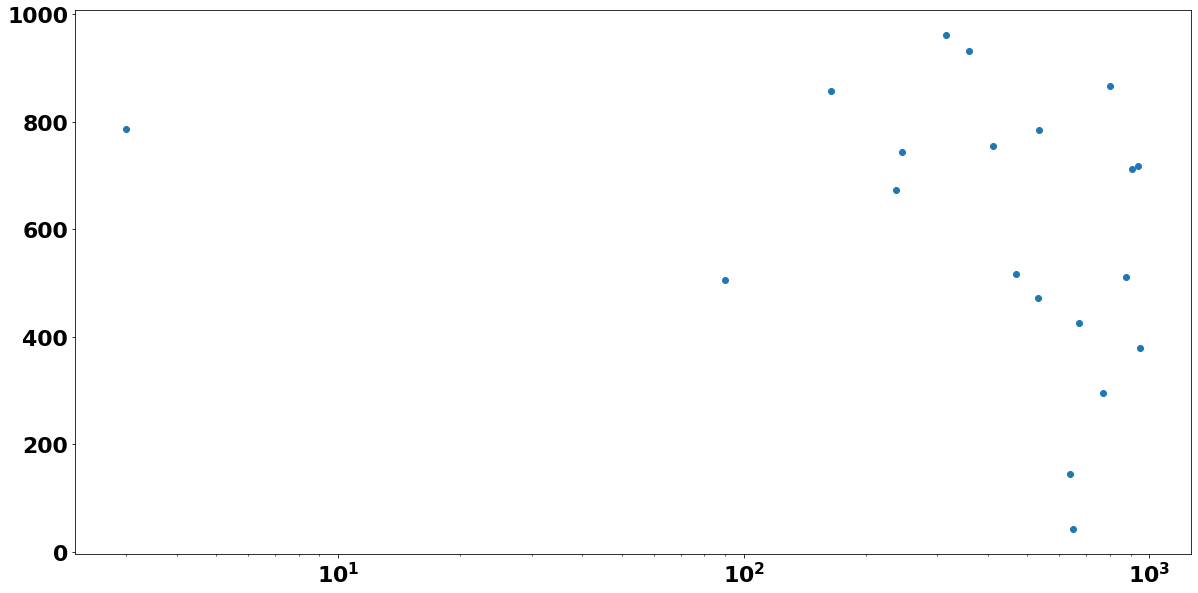

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)

x = np.random.randint(0,1000,size=20)
y = np.random.randint(0,1000,size=20)
plt.figure(figsize=(20,10))
plt.scatter(x, y)
plt.xscale('log')
plt.show()

In [20]:
import itertools

def fun(s,o,l,v,e):
    return 10000*s+500*o-4900*l-40*v-4*e

if __name__ == '__main__':
    for lperm in itertools.permutations([0,1,2,3,4,5,6,7,8,9], 5):
        if lperm[0] > 0:
            if fun(lperm[0],lperm[1],lperm[2],lperm[3],lperm[4]) == 0:
                print(lperm)

(3, 9, 7, 5, 0)


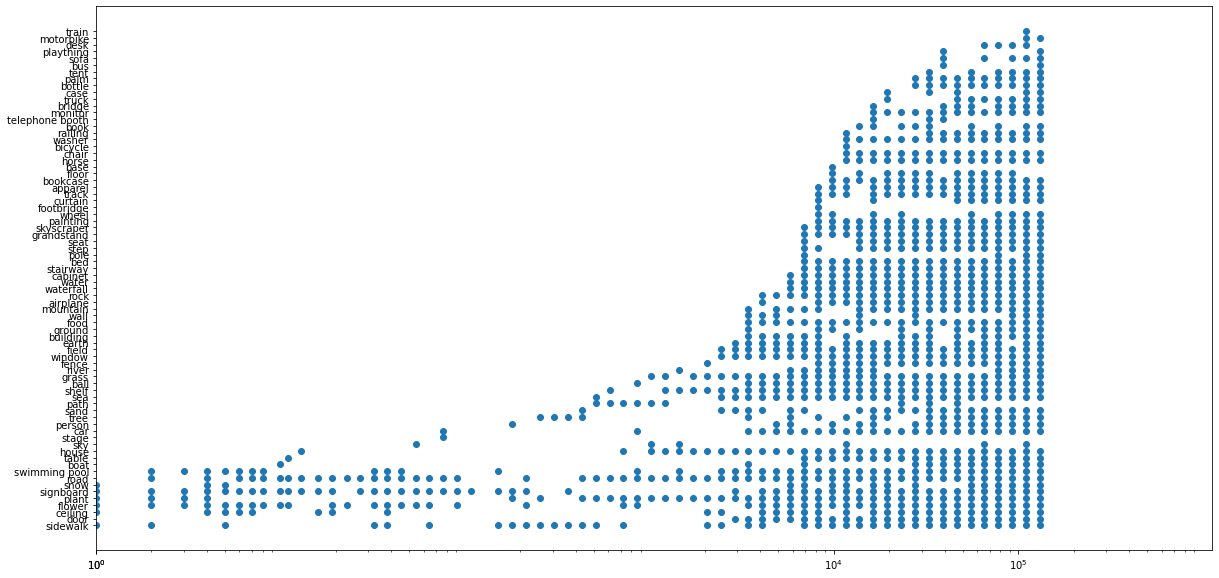

In [57]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

rc('font', **font)

x = [0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11, 13, 13, 13, 16, 16, 16, 19, 19, 19, 19, 23, 23, 27, 27, 32, 32, 32, 32, 32, 38, 38, 38, 38, 38, 38, 45, 45, 45, 45, 54, 54, 54, 54, 64, 64, 64, 64, 76, 76, 76, 76, 91, 91, 91, 108, 152, 152, 152, 181, 181, 181, 181, 215, 215, 215, 215, 256, 256, 256, 304, 304, 362, 362, 362, 431, 431, 431, 431, 431, 512, 512, 512, 512, 512, 609, 609, 609, 609, 724, 724, 724, 724, 724, 724, 861, 861, 861, 861, 861, 861, 861, 1024, 1024, 1024, 1024, 1024, 1024, 1218, 1218, 1218, 1218, 1218, 1218, 1448, 1448, 1448, 1448, 1448, 1448, 1448, 1722, 1722, 1722, 1722, 1722, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072]
#x = [v*math.exp(0.0001*(131072-v)) for v in x]
y = ('sidewalk', 'door', 'ceiling', 'flower', 'ceiling', 'sidewalk', 'plant', 'signboard', 'snow', 'flower', 'sidewalk', 'road', 'swimming pool', 'plant', 'signboard', 'flower', 'signboard', 'swimming pool', 'plant', 'flower', 'ceiling', 'road', 'swimming pool', 'plant', 'signboard', 'snow', 'flower', 'ceiling', 'sidewalk', 'swimming pool', 'signboard', 'snow', 'flower', 'ceiling', 'road', 'swimming pool', 'signboard', 'flower', 'ceiling', 'road', 'swimming pool', 'signboard', 'flower', 'road', 'swimming pool', 'signboard', 'flower', 'signboard', 'road', 'boat', 'flower', 'table', 'signboard', 'road', 'signboard', 'road', 'house', 'signboard', 'road', 'ceiling', 'flower', 'road', 'signboard', 'ceiling', 'flower', 'road', 'road', 'signboard', 'flower', 'sidewalk', 'road', 'swimming pool', 'signboard', 'flower', 'ceiling', 'sidewalk', 'road', 'swimming pool', 'signboard', 'flower', 'signboard', 'road', 'swimming pool', 'flower', 'signboard', 'road', 'sky', 'flower', 'sidewalk', 'signboard', 'road', 'road', 'stage', 'car', 'signboard', 'flower', 'signboard', 'road', 'signboard', 'sidewalk', 'signboard', 'swimming pool', 'plant', 'sidewalk', 'signboard', 'person', 'flower', 'sidewalk', 'signboard', 'road', 'sidewalk', 'plant', 'tree', 'sidewalk', 'tree', 'sidewalk', 'signboard', 'tree', 'tree', 'sidewalk', 'road', 'plant', 'sand', 'path', 'sidewalk', 'road', 'plant', 'sea', 'path', 'shelf', 'road', 'plant', 'flower', 'path', 'sidewalk', 'road', 'plant', 'house', 'flower', 'path', 'road', 'swimming pool', 'plant', 'car', 'ball', 'path', 'road', 'plant', 'grass', 'sky', 'house', 'path', 'shelf', 'road', 'plant', 'grass', 'house', 'shelf', 'road', 'swimming pool', 'plant', 'river', 'sky', 'house', 'shelf', 'road', 'plant', 'grass', 'house', 'fence', 'ceiling', 'sidewalk', 'shelf', 'road', 'plant', 'grass', 'house', 'window', 'ceiling', 'sidewalk', 'shelf', 'road', 'swimming pool', 'field', 'plant', 'grass', 'sea', 'house', 'sand', 'window', 'shelf', 'road', 'earth', 'swimming pool', 'plant', 'field', 'grass', 'signboard', 'door', 'sea', 'house', 'sand', 'window', 'tree', 'sidewalk', 'shelf', 'field', 'grass', 'plant', 'building', 'ball', 'sea', 'ground', 'boat', 'house', 'food', 'earth', 'flower', 'road', 'swimming pool', 'wall', 'car', 'mountain', 'door', 'sand', 'window', 'sidewalk', 'shelf', 'airplane', 'field', 'grass', 'rock', 'plant', 'building', 'ball', 'sea', 'house', 'food', 'earth', 'signboard', 'flower', 'ceiling', 'road', 'swimming pool', 'wall', 'car', 'door', 'sand', 'window', 'shelf', 'field', 'grass', 'rock', 'door', 'plant', 'building', 'ball', 'sea', 'house', 'food', 'earth', 'signboard', 'flower', 'ceiling', 'road', 'swimming pool', 'wall', 'car', 'mountain', 'person', 'window', 'tree', 'shelf', 'field', 'grass', 'rock', 'waterfall', 'water', 'door', 'plant', 'building', 'ball', 'sea', 'house', 'food', 'earth', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'road', 'swimming pool', 'river', 'mountain', 'car', 'person', 'sand', 'window', 'sidewalk', 'shelf', 'table', 'field', 'grass', 'rock', 'waterfall', 'water', 'plant', 'stairway', 'bed', 'building', 'ball', 'sea', 'house', 'boat', 'pole', 'food', 'earth', 'step', 'seat', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'tree', 'sidewalk', 'shelf', 'airplane', 'table', 'field', 'painting', 'grass', 'wheel', 'rock', 'waterfall', 'footbridge', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'house', 'food', 'earth', 'step', 'signboard', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'mountain', 'car', 'door', 'skyscraper', 'window', 'fence', 'bookcase', 'sidewalk', 'shelf', 'airplane', 'table', 'field', 'painting', 'grass', 'wheel', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'floor', 'sea', 'ground', 'apparel', 'house', 'base', 'person', 'food', 'signboard', 'snow', 'cabinet', 'flower', 'grandstand', 'road', 'swimming pool', 'river', 'car', 'door', 'skyscraper', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'sidewalk', 'tree', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'sky', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'house', 'bicycle', 'food', 'earth', 'washer', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'car', 'door', 'railing', 'skyscraper', 'window', 'fence', 'horse', 'bookcase', 'sidewalk', 'shelf', 'airplane', 'table', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'plant', 'stairway', 'bed', 'ball', 'floor', 'sea', 'ground', 'house', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'flower', 'grandstand', 'road', 'swimming pool', 'wall', 'book', 'river', 'mountain', 'car', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'sidewalk', 'telephone booth', 'tree', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'curtain', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'apparel', 'sea', 'house', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'road', 'grandstand', 'swimming pool', 'book', 'river', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'tree', 'table', 'shelf', 'airplane', 'horse', 'sidewalk', 'truck', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'apparel', 'sea', 'floor', 'house', 'monitor', 'food', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'case', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'horse', 'bookcase', 'table', 'shelf', 'airplane', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'floor', 'ground', 'house', 'monitor', 'food', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'flower', 'ceiling', 'path', 'road', 'grandstand', 'swimming pool', 'book', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'sidewalk', 'bottle', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'apparel', 'sea', 'ball', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'road', 'grandstand', 'swimming pool', 'wall', 'book', 'mountain', 'car', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'telephone booth', 'airplane', 'tree', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'ball', 'sea', 'ground', 'apparel', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'case', 'flower', 'ceiling', 'path', 'grandstand', 'road', 'swimming pool', 'book', 'bottle', 'mountain', 'car', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bus', 'bookcase', 'tree', 'table', 'shelf', 'telephone booth', 'horse', 'airplane', 'bottle', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'apparel', 'sea', 'house', 'boat', 'palm', 'monitor', 'person', 'food', 'sofa', 'step', 'seat', 'washer', 'plaything', 'signboard', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'car', 'mountain', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'truck', 'sidewalk', 'tree', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'apparel', 'sea', 'ball', 'ground', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'case', 'bridge', 'flower', 'ceiling', 'path', 'grandstand', 'road', 'swimming pool', 'bottle', 'mountain', 'car', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'shelf', 'horse', 'airplane', 'truck', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'floor', 'apparel', 'sea', 'ground', 'ball', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'book', 'bottle', 'mountain', 'car', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'desk', 'sidewalk', 'field', 'painting', 'grass', 'truck', 'chair', 'rock', 'waterfall', 'sky', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'apparel', 'sea', 'ground', 'ball', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'sofa', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'bottle', 'mountain', 'car', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'truck', 'desk', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'wheel', 'rock', 'waterfall', 'curtain', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'floor', 'house', 'boat', 'palm', 'pole', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'book', 'bottle', 'mountain', 'car', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'horse', 'shelf', 'airplane', 'table', 'truck', 'desk', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'wheel', 'rock', 'waterfall', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'floor', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'sofa', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'wall', 'river', 'bottle', 'car', 'mountain', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'truck', 'desk', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'wheel', 'rock', 'waterfall', 'sky', 'curtain', 'door', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'motorbike', 'house', 'boat', 'palm', 'pole', 'monitor', 'food', 'sofa', 'earth', 'step', 'seat', 'washer', 'signboard', 'train', 'snow', 'cabinet', 'case', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'wall', 'river', 'book', 'bottle', 'car', 'mountain', 'tent', 'person', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bus', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'truck', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'curtain', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'motorbike', 'house', 'boat', 'palm', 'pole', 'monitor', 'food', 'person', 'sofa', 'earth', 'step', 'seat', 'washer', 'plaything', 'signboard', 'snow', 'cabinet', 'case', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'wall', 'river', 'book', 'bottle', 'car', 'mountain', 'tent', 'door', 'railing', 'skyscraper', 'sand')
fig, ax1 = plt.subplots(figsize=(20,10))
#plt.figure(figsize=(20,10))
#plt.scatter(x, y)
ax1.scatter(x, y)
#plt.xscale('log')
ax1.set_xscale('log')
ax1.set_xticks([1, 10000, 1, 100000])
plt.show()

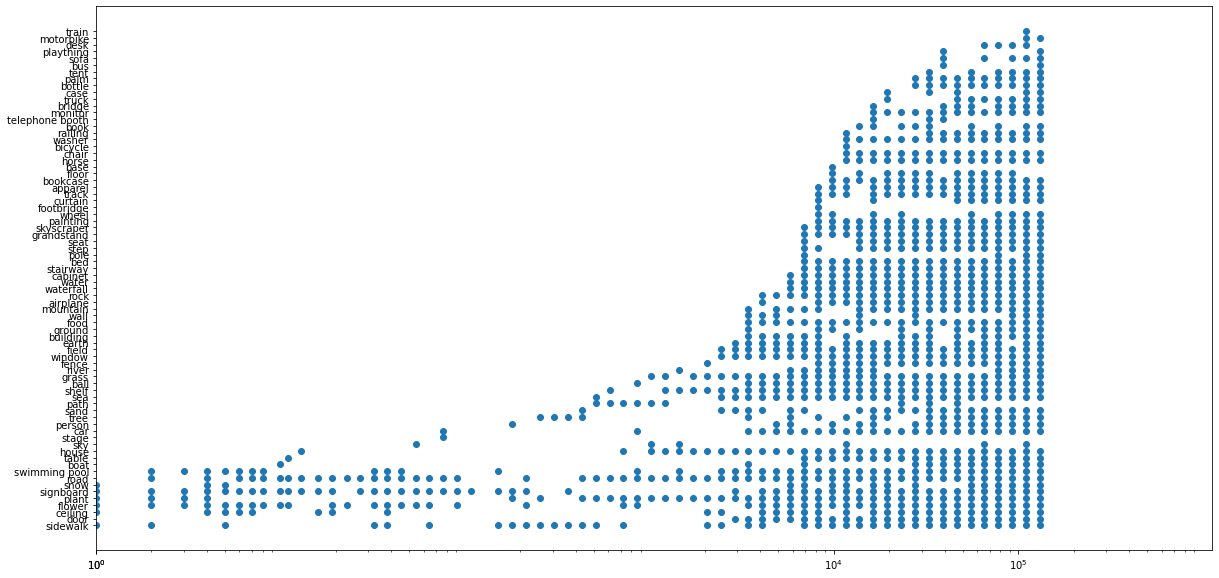

In [58]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

rc('font', **font)

x = [0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11, 13, 13, 13, 16, 16, 16, 19, 19, 19, 19, 23, 23, 27, 27, 32, 32, 32, 32, 32, 38, 38, 38, 38, 38, 38, 45, 45, 45, 45, 54, 54, 54, 54, 64, 64, 64, 64, 76, 76, 76, 76, 91, 91, 91, 108, 152, 152, 152, 181, 181, 181, 181, 215, 215, 215, 215, 256, 256, 256, 304, 304, 362, 362, 362, 431, 431, 431, 431, 431, 512, 512, 512, 512, 512, 609, 609, 609, 609, 724, 724, 724, 724, 724, 724, 861, 861, 861, 861, 861, 861, 861, 1024, 1024, 1024, 1024, 1024, 1024, 1218, 1218, 1218, 1218, 1218, 1218, 1448, 1448, 1448, 1448, 1448, 1448, 1448, 1722, 1722, 1722, 1722, 1722, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072]
#x = [v*math.exp(0.0001*(131072-v)) for v in x]
y = ('sidewalk', 'door', 'ceiling', 'flower', 'ceiling', 'sidewalk', 'plant', 'signboard', 'snow', 'flower', 'sidewalk', 'road', 'swimming pool', 'plant', 'signboard', 'flower', 'signboard', 'swimming pool', 'plant', 'flower', 'ceiling', 'road', 'swimming pool', 'plant', 'signboard', 'snow', 'flower', 'ceiling', 'sidewalk', 'swimming pool', 'signboard', 'snow', 'flower', 'ceiling', 'road', 'swimming pool', 'signboard', 'flower', 'ceiling', 'road', 'swimming pool', 'signboard', 'flower', 'road', 'swimming pool', 'signboard', 'flower', 'signboard', 'road', 'boat', 'flower', 'table', 'signboard', 'road', 'signboard', 'road', 'house', 'signboard', 'road', 'ceiling', 'flower', 'road', 'signboard', 'ceiling', 'flower', 'road', 'road', 'signboard', 'flower', 'sidewalk', 'road', 'swimming pool', 'signboard', 'flower', 'ceiling', 'sidewalk', 'road', 'swimming pool', 'signboard', 'flower', 'signboard', 'road', 'swimming pool', 'flower', 'signboard', 'road', 'sky', 'flower', 'sidewalk', 'signboard', 'road', 'road', 'stage', 'car', 'signboard', 'flower', 'signboard', 'road', 'signboard', 'sidewalk', 'signboard', 'swimming pool', 'plant', 'sidewalk', 'signboard', 'person', 'flower', 'sidewalk', 'signboard', 'road', 'sidewalk', 'plant', 'tree', 'sidewalk', 'tree', 'sidewalk', 'signboard', 'tree', 'tree', 'sidewalk', 'road', 'plant', 'sand', 'path', 'sidewalk', 'road', 'plant', 'sea', 'path', 'shelf', 'road', 'plant', 'flower', 'path', 'sidewalk', 'road', 'plant', 'house', 'flower', 'path', 'road', 'swimming pool', 'plant', 'car', 'ball', 'path', 'road', 'plant', 'grass', 'sky', 'house', 'path', 'shelf', 'road', 'plant', 'grass', 'house', 'shelf', 'road', 'swimming pool', 'plant', 'river', 'sky', 'house', 'shelf', 'road', 'plant', 'grass', 'house', 'fence', 'ceiling', 'sidewalk', 'shelf', 'road', 'plant', 'grass', 'house', 'window', 'ceiling', 'sidewalk', 'shelf', 'road', 'swimming pool', 'field', 'plant', 'grass', 'sea', 'house', 'sand', 'window', 'shelf', 'road', 'earth', 'swimming pool', 'plant', 'field', 'grass', 'signboard', 'door', 'sea', 'house', 'sand', 'window', 'tree', 'sidewalk', 'shelf', 'field', 'grass', 'plant', 'building', 'ball', 'sea', 'ground', 'boat', 'house', 'food', 'earth', 'flower', 'road', 'swimming pool', 'wall', 'car', 'mountain', 'door', 'sand', 'window', 'sidewalk', 'shelf', 'airplane', 'field', 'grass', 'rock', 'plant', 'building', 'ball', 'sea', 'house', 'food', 'earth', 'signboard', 'flower', 'ceiling', 'road', 'swimming pool', 'wall', 'car', 'door', 'sand', 'window', 'shelf', 'field', 'grass', 'rock', 'door', 'plant', 'building', 'ball', 'sea', 'house', 'food', 'earth', 'signboard', 'flower', 'ceiling', 'road', 'swimming pool', 'wall', 'car', 'mountain', 'person', 'window', 'tree', 'shelf', 'field', 'grass', 'rock', 'waterfall', 'water', 'door', 'plant', 'building', 'ball', 'sea', 'house', 'food', 'earth', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'road', 'swimming pool', 'river', 'mountain', 'car', 'person', 'sand', 'window', 'sidewalk', 'shelf', 'table', 'field', 'grass', 'rock', 'waterfall', 'water', 'plant', 'stairway', 'bed', 'building', 'ball', 'sea', 'house', 'boat', 'pole', 'food', 'earth', 'step', 'seat', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'tree', 'sidewalk', 'shelf', 'airplane', 'table', 'field', 'painting', 'grass', 'wheel', 'rock', 'waterfall', 'footbridge', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'house', 'food', 'earth', 'step', 'signboard', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'mountain', 'car', 'door', 'skyscraper', 'window', 'fence', 'bookcase', 'sidewalk', 'shelf', 'airplane', 'table', 'field', 'painting', 'grass', 'wheel', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'floor', 'sea', 'ground', 'apparel', 'house', 'base', 'person', 'food', 'signboard', 'snow', 'cabinet', 'flower', 'grandstand', 'road', 'swimming pool', 'river', 'car', 'door', 'skyscraper', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'sidewalk', 'tree', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'sky', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'house', 'bicycle', 'food', 'earth', 'washer', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'car', 'door', 'railing', 'skyscraper', 'window', 'fence', 'horse', 'bookcase', 'sidewalk', 'shelf', 'airplane', 'table', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'plant', 'stairway', 'bed', 'ball', 'floor', 'sea', 'ground', 'house', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'flower', 'grandstand', 'road', 'swimming pool', 'wall', 'book', 'river', 'mountain', 'car', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'sidewalk', 'telephone booth', 'tree', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'curtain', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'apparel', 'sea', 'house', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'road', 'grandstand', 'swimming pool', 'book', 'river', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'tree', 'table', 'shelf', 'airplane', 'horse', 'sidewalk', 'truck', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'apparel', 'sea', 'floor', 'house', 'monitor', 'food', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'case', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'horse', 'bookcase', 'table', 'shelf', 'airplane', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'floor', 'ground', 'house', 'monitor', 'food', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'flower', 'ceiling', 'path', 'road', 'grandstand', 'swimming pool', 'book', 'car', 'mountain', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'sidewalk', 'bottle', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'apparel', 'sea', 'ball', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'road', 'grandstand', 'swimming pool', 'wall', 'book', 'mountain', 'car', 'door', 'skyscraper', 'sand', 'window', 'fence', 'bookcase', 'horse', 'table', 'shelf', 'telephone booth', 'airplane', 'tree', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'ball', 'sea', 'ground', 'apparel', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'case', 'flower', 'ceiling', 'path', 'grandstand', 'road', 'swimming pool', 'book', 'bottle', 'mountain', 'car', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bus', 'bookcase', 'tree', 'table', 'shelf', 'telephone booth', 'horse', 'airplane', 'bottle', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'rock', 'waterfall', 'water', 'track', 'plant', 'stairway', 'bed', 'ball', 'apparel', 'sea', 'house', 'boat', 'palm', 'monitor', 'person', 'food', 'sofa', 'step', 'seat', 'washer', 'plaything', 'signboard', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'car', 'mountain', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'horse', 'table', 'shelf', 'airplane', 'truck', 'sidewalk', 'tree', 'field', 'painting', 'grass', 'chair', 'rock', 'waterfall', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'apparel', 'sea', 'ball', 'ground', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'cabinet', 'case', 'bridge', 'flower', 'ceiling', 'path', 'grandstand', 'road', 'swimming pool', 'bottle', 'mountain', 'car', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'shelf', 'horse', 'airplane', 'truck', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'floor', 'apparel', 'sea', 'ground', 'ball', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'book', 'bottle', 'mountain', 'car', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'desk', 'sidewalk', 'field', 'painting', 'grass', 'truck', 'chair', 'rock', 'waterfall', 'sky', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'floor', 'apparel', 'sea', 'ground', 'ball', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'sofa', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'bottle', 'mountain', 'car', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'truck', 'desk', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'wheel', 'rock', 'waterfall', 'curtain', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'floor', 'house', 'boat', 'palm', 'pole', 'monitor', 'food', 'person', 'earth', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'river', 'book', 'bottle', 'mountain', 'car', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'horse', 'shelf', 'airplane', 'table', 'truck', 'desk', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'wheel', 'rock', 'waterfall', 'water', 'curtain', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'floor', 'house', 'boat', 'palm', 'monitor', 'food', 'person', 'sofa', 'step', 'seat', 'washer', 'signboard', 'snow', 'cabinet', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'wall', 'river', 'bottle', 'car', 'mountain', 'tent', 'door', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'truck', 'desk', 'field', 'painting', 'grass', 'sidewalk', 'chair', 'wheel', 'rock', 'waterfall', 'sky', 'curtain', 'door', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'motorbike', 'house', 'boat', 'palm', 'pole', 'monitor', 'food', 'sofa', 'earth', 'step', 'seat', 'washer', 'signboard', 'train', 'snow', 'cabinet', 'case', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'wall', 'river', 'book', 'bottle', 'car', 'mountain', 'tent', 'person', 'railing', 'skyscraper', 'sand', 'fence', 'window', 'bus', 'bookcase', 'tree', 'table', 'horse', 'airplane', 'shelf', 'truck', 'sidewalk', 'field', 'painting', 'grass', 'chair', 'wheel', 'rock', 'waterfall', 'curtain', 'water', 'track', 'plant', 'stairway', 'bed', 'building', 'ball', 'apparel', 'sea', 'ground', 'motorbike', 'house', 'boat', 'palm', 'pole', 'monitor', 'food', 'person', 'sofa', 'earth', 'step', 'seat', 'washer', 'plaything', 'signboard', 'snow', 'cabinet', 'case', 'bridge', 'flower', 'ceiling', 'grandstand', 'road', 'swimming pool', 'wall', 'river', 'book', 'bottle', 'car', 'mountain', 'tent', 'door', 'railing', 'skyscraper', 'sand')
fig, ax1 = plt.subplots(figsize=(20,10))
#plt.figure(figsize=(20,10))
#plt.scatter(x, y)
ax1.scatter(x, y)
#plt.xscale('log')
ax1.set_xscale('log')
ax1.set_xticks([1, 10000, 1, 100000])
plt.show()

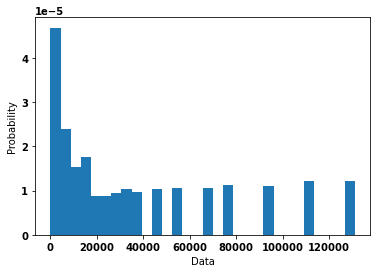

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#np.random.seed(42)
#x = np.random.normal(size=1000)
x = [0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11, 13, 13, 13, 16, 16, 16, 19, 19, 19, 19, 23, 23, 27, 27, 32, 32, 32, 32, 32, 38, 38, 38, 38, 38, 38, 45, 45, 45, 45, 54, 54, 54, 54, 64, 64, 64, 64, 76, 76, 76, 76, 91, 91, 91, 108, 152, 152, 152, 181, 181, 181, 181, 215, 215, 215, 215, 256, 256, 256, 304, 304, 362, 362, 362, 431, 431, 431, 431, 431, 512, 512, 512, 512, 512, 609, 609, 609, 609, 724, 724, 724, 724, 724, 724, 861, 861, 861, 861, 861, 861, 861, 1024, 1024, 1024, 1024, 1024, 1024, 1218, 1218, 1218, 1218, 1218, 1218, 1448, 1448, 1448, 1448, 1448, 1448, 1448, 1722, 1722, 1722, 1722, 1722, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2435, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 2896, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 3444, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 4871, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 5793, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 6889, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 9742, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 11585, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 13777, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 19484, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 23170, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 27554, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 32768, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 38968, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 46341, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 55109, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 77936, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 92682, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 110218, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072, 131072]

plt.hist(x, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

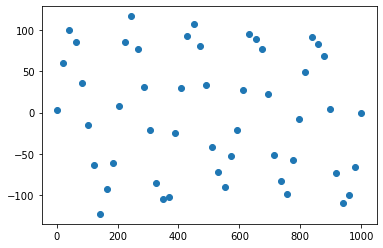

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math

x = np.linspace(1, 1000)
#y = 100*(np.sin(x/5) + np.random.normal(scale=0.1, size=len(x))) # <- your solution
#y = 100*(np.sin(x/1000*2*math.pi)) # <- one full period
#y = 100*(np.sin(x/1000*2*math.pi*5)) # <- 5 full periods
y = 100*(np.sin(x/1000*2*math.pi*5) + np.random.normal(scale=0.1, size=len(x))) # <- 5 full periods + noise
plt.scatter(x, y)
plt.show()  

In [36]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
#from prettytable import PrettyTable

x_m = [1, 2, 3, 4] 
alpha = [5, 6, 7, 8]

#drawing samples from distribution

for a, x in zip(alpha, x_m):
    print (a, x)
data = (np.random.default_rng().pareto(a, 1000) + 1) * x
mean = np.mean(data) 
var = np.var(data) 
skew = skew(data) 
kurt = kurtosis(data)

#Analytical estimation

for a, x in zip(alpha, x_m):
    a_mean = (a*x)/(a-1)
    a_var = (a*x**2)/((a-1)**2*(a-2))
    a_skew = (2*(1+a)/(a-3))*(np.sqrt((a-2)/a))
    a_kurt = (6*(a**3+a**2-6*a-2))/(a*(a-3)*(a-4))
    
#Table

#header = ['Moments', 'Simulated', 'Analytical']
Moments = ['Mean', 'Variance', 'Skewness', 'Excess Kurtosis']
Simulated = [round(mean,4), round(var,4), round(skew,4), round(kurt,4)]
Analytical = [round(a_mean,4), round(a_var,4), round(a_skew,4), round(a_kurt,4)]
#table = PrettyTable()

#table.add_column(header[0], Moments)
#table.add_column(header[1], Simulated)
#table.add_column(header[2], Analytical)
#print(table)
print(Moments)
print(Simulated)
print(Analytical)

5 1
6 2
7 3
8 4
['Mean', 'Variance', 'Skewness', 'Excess Kurtosis']
[4.5861, 0.4476, 3.0928, 17.5114]
[4.5714, 0.4354, 3.1177, 19.725]


In [39]:
import collections
s = [('eng1','abc.html'),('eng2','def.html'),('eng3','unn/ttt.html'),        
('chielse','yyy.html'),('chi3','unn/ttt.html'),('chi1','abc.html'), 
('sc3','unn/ttt.html'),('sc1','abc.html'),('sc2','def.html'), 
('schhh','ppp.html')]

d = collections.defaultdict(list)
for k, v in s:
    #d[k].append(v)
    d[v].append(k)

print(list(d.items()))

[('abc.html', ['eng1', 'chi1', 'sc1']), ('def.html', ['eng2', 'sc2']), ('unn/ttt.html', ['eng3', 'chi3', 'sc3']), ('yyy.html', ['chielse']), ('ppp.html', ['schhh'])]


In [1]:
from itertools import product
 
def gen_dict(n_faces, n_dice):
    counts = [0] * ((n_faces + 1) * n_dice)
    for t in product(range(1, n_faces + 1), repeat=n_dice):
        counts[sum(t)] += 1
    return counts, n_faces ** n_dice
 
def beating_probability(n_sides1, n_dice1, n_sides2, n_dice2):
    c1, p1 = gen_dict(n_sides1, n_dice1)
    c2, p2 = gen_dict(n_sides2, n_dice2)
    p12 = float(p1 * p2)
 
    return sum(p[1] * q[1] / p12
               for p, q in product(enumerate(c1), enumerate(c2))
               if p[0] > q[0])
 
print(beating_probability(4, 9, 6, 6))
print(beating_probability(10, 5, 7, 6))

0.5731440767829815
0.6427886287176273


In [1]:
# Pigeon hole principle
import random

def rdpick(n, itms):
    res = []
    for i in range(n):
        thisitm = random.choice(itms)
        itms.remove(thisitm)
        res.append(thisitm)
    return res

if __name__ == '__main__':
    print(rdpick(5, [1,2,3,4,5,6,7,8]))

[1, 7, 2, 6, 4]


In [1]:
# Determine if a string has all the same characters

def diffchr(strg):
    '''determine if all characters are the same'''
    return [idx for idx, itm in enumerate(list(strg)) if itm != list(strg)[idx-1] and idx > 0]

if __name__ == '__main__':
    print(diffchr('aaaaaabaaaaa'))
    print(diffchr('abaaaabaabaa'))

[6, 7]
[1, 2, 6, 7, 9, 10]


In [24]:
import pandas as pd

df = pd.DataFrame({'event_type': ['watch movie ', 'stay at home', 'swimming','camping','meeting'], 
               'date': ['8/11/2020', '2/13/2020', '7/04/2020','1/22/2020','7/28/2020'],
                'event_mohafaza':['loc1','loc3','loc2','loc5','loc4'],
                 ' number_person ':[24,39,20,10,33],})

print(df)
        
non_numeric_cols = [col for col, col_type in df.dtypes.iteritems() if col_type == 'object']
if len(non_numeric_cols) > 0:
    #mask = df.astype(str).apply(lambda x : x.str.match('[0-3]?[0-9]-[0-3]?[0-9]-(?:[0-9]{2})?[0-9]{2}$').any())
    mask = df.astype(str).apply(lambda x : x.str.match('^([1-9]|1[0-9]|2[0-9]|3[0-1])(.|-|/)([1-9]|1[0-2])(.|-|/)20[0-9][0-9]$').any())
            
    if mask.any() == True:
        df.loc[:,mask] = df.loc[:,mask].apply(pd.to_datetime,dayfirst=False)
        converteddate = [col for col in df.columns if df[col].dtype == 'datetime64[ns]']
    df = df.rename(columns={converteddate[0]: 'date'})
    if "date" in df.columns:
        df['year_month'] = df['date'].map(lambda x: x.strftime('%Y/%m'))
        
    print(df)

     event_type       date event_mohafaza   number_person 
0  watch movie   8/11/2020           loc1               24
1  stay at home  2/13/2020           loc3               39
2      swimming  7/04/2020           loc2               20
3       camping  1/22/2020           loc5               10
4       meeting  7/28/2020           loc4               33
     event_type       date event_mohafaza   number_person  year_month
0  watch movie  2020-08-11           loc1               24    2020/08
1  stay at home 2020-02-13           loc3               39    2020/02
2      swimming 2020-07-04           loc2               20    2020/07
3       camping 2020-01-22           loc5               10    2020/01
4       meeting 2020-07-28           loc4               33    2020/07


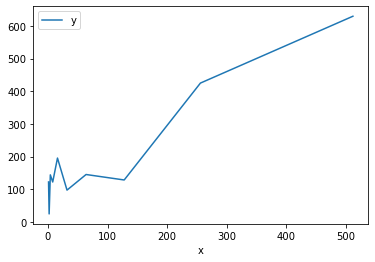

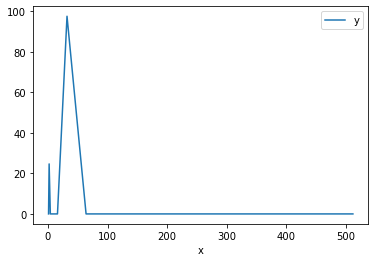

In [1]:
import numpy as np 
import pandas as pd 

x_val = [1,2,4,8,16,32,64,128,256,512]
y_val = [x+np.random.random()*200 for x in x_val]

df = pd.DataFrame(data={'x':x_val,'y':y_val})
df.set_index('x', inplace=True)

df.plot()

#print(df.mask(df > 100, 0))

#df.rolling(1, win_type='gaussian').mean(std=2).plot()
df.mask(df > 100, 0).rolling(1, win_type='gaussian').mean(std=2).plot()

In [1]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import multivariate_normal as mvn
import pandas as pd
import matplotlib.pyplot as plt 

n_sz = 10000
cov = np.array([[1, .11],[.11, 1]])
scores = mvn.rvs(mean = [1.,100.], cov=cov, size = n_sz)
df = pd.DataFrame(data = scores, columns = ["St", "St_2"])

print(df)
print(df.corr())
print(df.std())

print(np.sqrt(n_sz-2)*df.corr()/np.sqrt(1-df.corr()**2))
print(np.array(np.sqrt(n_sz-2)*df.corr()/np.sqrt(1-df.corr()**2))[0,1])

'''X = list(range(10,1000,10))
Y = []
for n_sz in range(1,1000,10):
    scores = mvn.rvs(mean = [1.,100.], cov=cov, size = n_sz)
    df = pd.DataFrame(data = scores, columns = ["St", "St_2"])
    Y.append(np.array(np.sqrt(n_sz-2)*df.corr()/np.sqrt(1-df.corr()**2))[0,1])
    
print(X,Y)
plt.scatter(X, Y)
plt.show()'''

            St        St_2
0     0.521309  100.665846
1     1.355264   99.123826
2     2.423752   99.550194
3     1.751086   99.195477
4     2.659344  100.286474
...        ...         ...
9995  2.301342  101.416906
9996  0.872337   99.519401
9997  1.358399  101.104821
9998  2.137664   99.135661
9999  0.845764   98.654116

[10000 rows x 2 columns]
           St     St_2
St    1.00000  0.09929
St_2  0.09929  1.00000
St      1.000784
St_2    1.007318
dtype: float64
            St      St_2
St         inf  9.977287
St_2  9.977287       inf
9.977287316796373


'X = list(range(10,1000,10))\nY = []\nfor n_sz in range(1,1000,10):\n    scores = mvn.rvs(mean = [1.,100.], cov=cov, size = n_sz)\n    df = pd.DataFrame(data = scores, columns = ["St", "St_2"])\n    Y.append(np.array(np.sqrt(n_sz-2)*df.corr()/np.sqrt(1-df.corr()**2))[0,1])\n    \nprint(X,Y)\nplt.scatter(X, Y)\nplt.show()'

In [1]:
from itertools import permutations, combinations_with_replacement

def clclin(coeffl, rslt, copl):
    '''simple forward solve'''
    if len(coeffl)!=len(copl)+1:
        return False
    cv = coeffl[0]
    for icf in range(len(copl)):
        if copl[icf]=='+':
            cv += coeffl[icf+1]
        elif copl[icf]=='-':
            cv -= coeffl[icf+1]
        elif copl[icf]=='*':
            cv *= coeffl[icf+1]
        elif copl[icf]=='/' and coeffl[icf+1]!=0:
            cv /= coeffl[icf+1]
        else:
            return False
    return cv==rslt

def clcop(coeffl, rslt, copl):
    '''consider precedence'''
    if len(coeffl)!=len(copl)+1:
        return False
    cv = [coeffl[0]]
    co = []
    for icf in range(len(copl)):
        if copl[icf]=='*':
            cv[-1] *= coeffl[icf+1]
        elif copl[icf]=='/':
            if coeffl[icf+1]!=0:
                cv[-1] /= coeffl[icf+1]
            else:
                return False
        else:
            cv.append(coeffl[icf+1])
            co.append(copl[icf])
    return clclin(cv, rslt, co)

def solvop(coeffl, rslt, vldop='+-*/'):
    '''try to solve coefficients combined via valid operators for given result'''
    if len(coeffl)==0: # only rudimentary error handling
        return []
    pcopl = []
    for p in combinations_with_replacement(vldop, len(coeffl)-1): # sloppily building all operator lists (can be improved)
        for el in permutations(p, len(coeffl)-1):
            pcopl.append(el)
    for copl in pcopl:
        if clcop(coeffl, rslt, copl): # use clclin for simple linear calculation w/o operator precedence
            return copl
    return []

print(list(solvop([1,2,4], 7)))
print(list(solvop([1,3,4], 7)))
print(list(solvop([1,2,4], 8)))
print(list(solvop([1,2,4], 1/8)))
print(list(solvop([1,2,0], 1/8)))
print(list(solvop([], 1/8)))
print(list(solvop([1,2,3], 7)))
print(list(solvop([1,2,0], 2)))
print(list(solvop([1,2,0,0,0,0], 2)))
print(list(solvop([0,0,0,0,2,0], 2)))
print(list(solvop([0,0,0,0,2,0], 5)))
print(list(solvop([0,0,0,0,-2,-1], 2)))

['+', '+']
['*', '+']
['*', '*']
['/', '/']
[]
[]
['+', '*']
['*', '+']
['*', '+', '+', '+', '+']
['+', '+', '+', '+', '+']
[]
['+', '+', '+', '+', '*']


C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


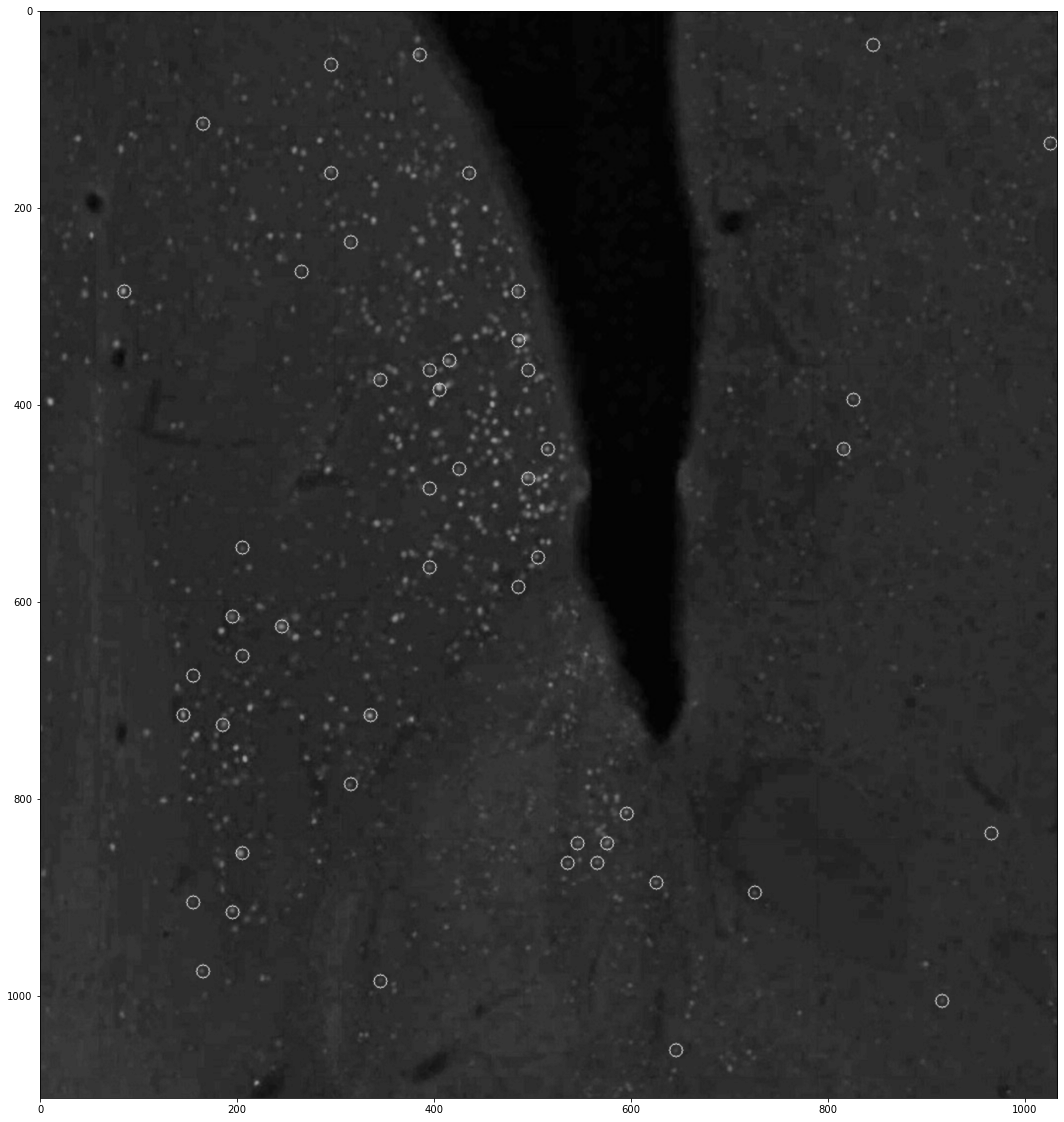

In [144]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

kernel= np.array([[ -2, -2,-1,-2,-2,-2,-1,-1,-2, -2],
                  [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -2],
                  [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -1],
                  [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -2],
                  [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -2],
                  [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -2],
                  [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -1],
                  [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -1],
                  [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -2],
                  [ -2, -2,-1,-2,-2,-2,-1,-1,-2, -2]])

prepath = ''
base_img = cv.imread(os.path.join(prepath, 'blevel.jpg'),0)

for i in range(0, base_img.shape[0]-10, 10):
    for j in range(0, base_img.shape[1]-10, 10):
        #print(i,j)
        baseimg_sub = base_img[i:i+10, j:j+10]
        baseimg_sub = baseimg_sub - np.min(baseimg_sub)
        baseimg_sub = np.round(baseimg_sub / np.max(baseimg_sub), 1)
        corr_factor = np.sum(np.multiply(baseimg_sub, kernel)) / 100
        if corr_factor > 0.1 :
            cv.circle(base_img, (j+5, i+5), 7, (255,255,255))
            
plt.figure(figsize=(30,20))
plt.imshow(base_img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


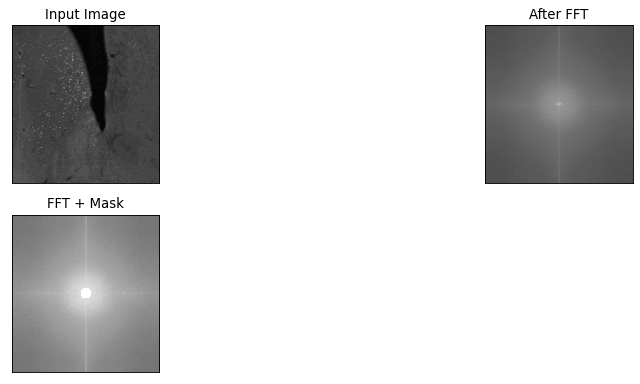

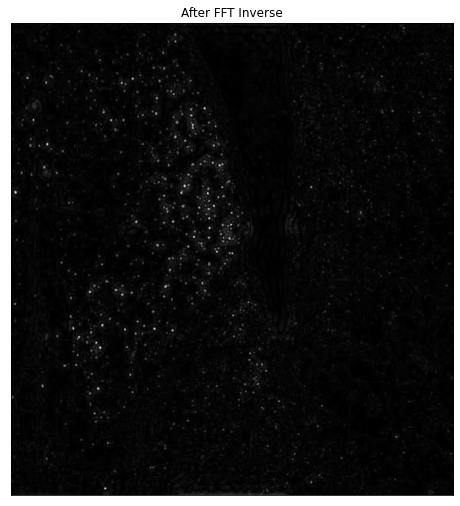

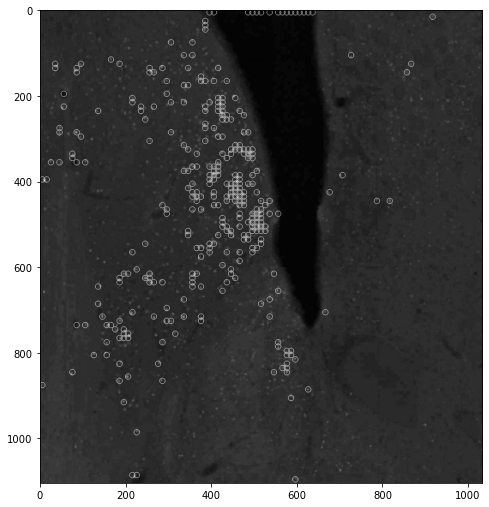

In [188]:
# https://akshaysin.github.io/fourier_transform.html

import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema
from scipy import fftpack

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        raise ValueError # "smooth only accepts 1 dimension arrays."
    if x.size < window_len:
        raise ValueError # "Input vector needs to be bigger than window size."
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError # "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(), s, mode='valid')
    return y

if __name__ == '__main__':
    img = cv2.imread('blevel.jpg', 0)
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum = 200 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)  # center

    # Circular HPF mask, center circle is 0, remaining all ones
    mask = np.ones((rows, cols, 2), np.uint8)
    r = 30
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r # circular
    #mask_area = abs((x - center[0]) + y * 0.)  <= r # directional x
    #mask_area = abs(x * 0. + (y - center[1]))  <= r # directional y
    mask[mask_area] = 0

    # apply mask and inverse DFT
    fshift = dft_shift * mask

    fshift_mask_mag = 1000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    prepath = ''
    base_img = cv.imread(os.path.join(prepath, 'blevel.jpg'),0)

    plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(4, 2, 1), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(4, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('After FFT'), plt.xticks([]), plt.yticks([])
    plt.subplot(4, 2, 3), plt.imshow(fshift_mask_mag, cmap='gray')
    plt.title('FFT + Mask'), plt.xticks([]), plt.yticks([])
    plt.figure(figsize=(60,40))
    plt.subplot(4, 2, 4), plt.imshow(img_back, cmap='gray')
    plt.title('After FFT Inverse'), plt.xticks([]), plt.yticks([])
    #plt.show()

    kernel= np.array([[ -2, -2,-1,-2,-2,-2,-1,-1,-2, -2],
                      [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -2],
                      [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -1],
                      [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -2],
                      [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -2],
                      [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -2],
                      [ -2,  0, 0, 2, 2, 2, 2, 0, 0, -1],
                      [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -1],
                      [ -2,  0, 0, 0, 0, 0, 0, 0, 0, -2],
                      [ -2, -2,-1,-2,-2,-2,-1,-1,-2, -2]])

    prepath = ''
    #base_img = cv.imread(os.path.join(prepath, 'blevel.jpg'),0)
    #blob_img = cv.imread(os.path.join(prepath, 'blob0.jpg'),0)
    #kernel = np.array(blob_img)
    #kernel = kernel - np.min(kernel)
    kx, ky = np.shape(kernel)
    ksum = np.sum(kernel)
    #imgsum = np.sum(img_back)
    #print(kx, ky, kernel)
    
    invlim = np.average(img_back) + 1.5*np.std(img_back)

    for i in range(0, img_back.shape[0]-kx, int(kx/1)):
        for j in range(0, img_back.shape[1]-ky, int(ky/1)):
            #print(i,j)
            baseimg_sub = img_back[i:i+kx, j:j+ky]
            #baseimg_sub = baseimg_sub - np.min(baseimg_sub)
            #baseimg_sub = np.round(baseimg_sub / np.max(baseimg_sub), 1)
            #corr_factor = np.sum(np.multiply(baseimg_sub, kernel)) / ksum / np.sum(baseimg_sub)
            corr_factor = np.average(baseimg_sub)
            if corr_factor > invlim:
                cv.circle(base_img, (j+5, i+5), 7, (255,255,255))

    plt.figure(figsize=(60,40))
    plt.subplot(4, 2, 5), plt.imshow(base_img, cmap='gray')
    plt.show()
